In [16]:
#Today:
#Plot delR distribution
#el_eta plot weird after delR cut
#WZ number after the cuts, number bad. #Figure out why WZ number so bad after the ==3 cut.
#redux with better cleaning 
#Add features, have a good story, add >=4 lep

#If time allows, do the same for 4leps, 
#Engineered variables would be different for >=4 case

In [1]:
#File Load Resetter
import importlib
import features_and_functions  # or whatever your .py file is named
importlib.reload(features_and_functions)

<module 'features_and_functions' from '/users/dbhandari/WZZtest/features_and_functions.py'>

# Data Loading and Preprocessing

In [2]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
import os
import vector 
import numpy as np
import copy
import pandas as pd
import sys
sys.path.append('.')  #this adds current directory to path if not already
from features_and_functions import delta_r, invariant_mass, compute_invariant_mass_4lep, compute_pt_4lepsys, compute_deltaR_4lep
from features_and_functions import transverse_mass, compute_event_shapes, compute_mt, total_event_et_ge4lep, compute_dphi_met_4lepsys
from features_and_functions import compute_best_z_candidate_masses_4lep, extract_features_geq4lep, clean_leptons, compute_mt_4l
from features_and_functions import compute_pairwise_masses_4lep, compute_triplet_masses_4lep, compute_delta_eta_phi_4lep, compute_delta_phi_between_Zs

import features_and_functions
print(dir(features_and_functions))

sns.set(style="whitegrid")

branches = [
    'el_pt', 'el_phi', 'el_eta', 'el_charge', 'nElectrons',
    'mu_pt', 'mu_phi', 'mu_eta', 'mu_charge', 'nMuons',
    'jet_pt', 'jet_phi', 'jet_eta', 'jet_mass', 'nJets',
    'jet_btag', 'MET', 'MET_Phi'
]

#loaading files
#wh_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WH_HToZZ_pythia8_events.root"
wh_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTrees_WH_HToZZ_pythia8_events_All.root"

wzz_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZZ_3leptons_ZUndecayed.root"
background_files = [
    "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZ_3lep_pythia8_events.root",
    "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_ZZ_pythia8_events.root"
]

#Or in a better way:
file_paths = {
    "WH": "/users/dbhandari/WZZAnalysisFiles/AnalysisTrees_WH_HToZZ_pythia8_events_All.root",

    "WZZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZZ_3leptons_ZUndecayed.root",
    #"WZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZ_3lep_pythia8_events.root",
    "ZZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_ZZ_pythia8_events.root"
}


def load_tree(file_path, branches):
    with uproot.open(file_path) as f:
        if file_path == wh_file:
            tree = f["PolarizationTree"]
        else:
            tree = f["LowPtSUSY_Tree"]
        return tree.arrays(branches, library="ak")

#loading signal and background data
signal_data = {
    "WH": load_tree(wh_file, branches),
    "WZZ": load_tree(wzz_file, branches),
}

background_data = {
    #"WZ": load_tree(background_files[0], branches),
    "ZZ": load_tree(background_files[0], branches),
}

#need output directory for plots
output_dir = "plots_normalized"
os.makedirs(output_dir, exist_ok=True)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'ak', 'behavior', 'clean_leptons', 'compute_best_z_candidate_masses', 'compute_best_z_candidate_masses_4lep', 'compute_best_z_candidate_pt', 'compute_deltaR_3lep', 'compute_deltaR_4lep', 'compute_delta_eta_phi_3lep', 'compute_delta_eta_phi_4lep', 'compute_delta_phi_Z_MET', 'compute_delta_phi_Z_lep', 'compute_delta_phi_between_Zs', 'compute_dphi_met_3lepsys', 'compute_dphi_met_4lepsys', 'compute_event_shapes', 'compute_event_shapes_exact', 'compute_invariant_mass_3lep', 'compute_invariant_mass_4lep', 'compute_mt', 'compute_mt_4l', 'compute_pairwise_masses_3lep', 'compute_pairwise_masses_4lep', 'compute_pt_3lepsys', 'compute_pt_4lepsys', 'compute_thrust', 'compute_triplet_masses_4lep', 'copy', 'delta_r', 'extract_features', 'extract_features_geq4lep', 'invariant_mass', 'mt_nonZ_lepton_MET', 'np', 'os', 'pd', 'sns', 'sys', 'total_event_et', 'total_event_et_ge4lep', 'transverse_mass',

## Making normalized plots of variables

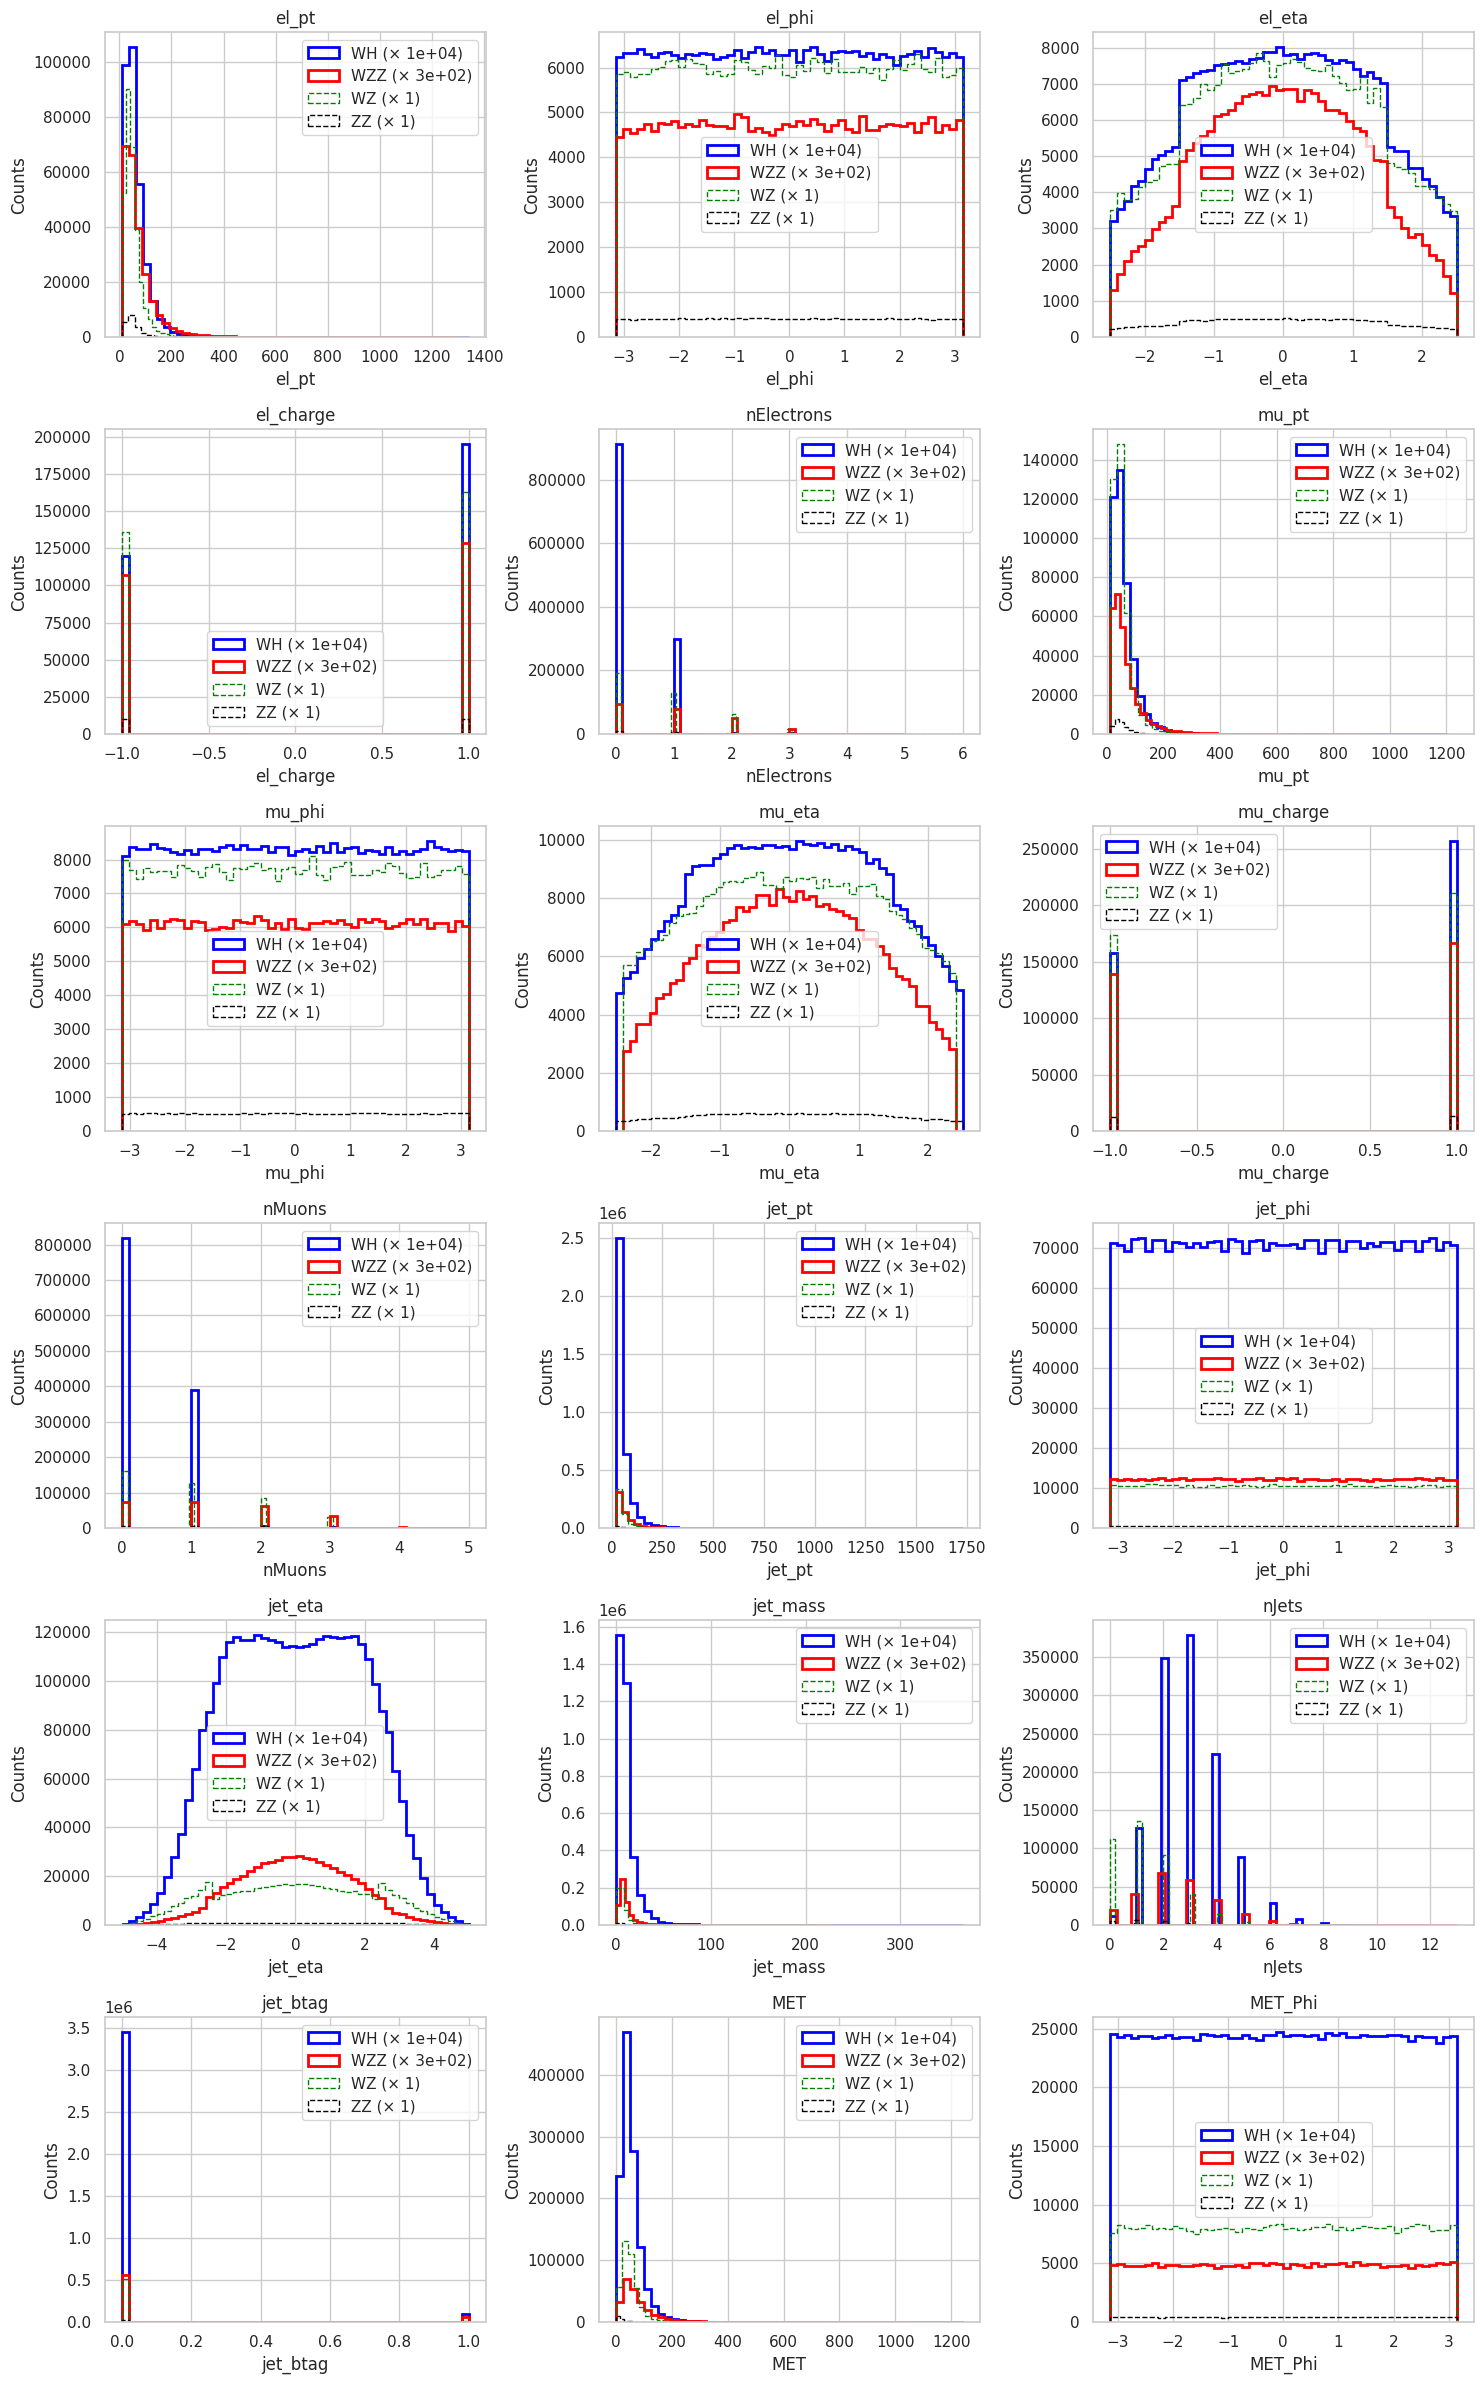

In [39]:
signal_colors = {
    "WH": "blue",
    "WZZ": "red",
}                                  #defining only once for sanity
background_colors = {
    #"WZ": "green",
    "ZZ": "black",
}
all_colors = {**signal_colors, **background_colors}

norm_factors = {
    "WH": 0.0001218 * 10000,
    "WZZ": 0.0081 * 300,
    #"WZ": 4.0,
    "ZZ": 0.196   #Why 4? New value used
}

multiplicative_factors = {
    "WH": 10000,
    "WZZ": 300,
   # "WZ": 1.0,
    "ZZ": 1.0
}

n_cols = 3
n_rows = int(np.ceil(len(branches) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))   #plot layout
axes = axes.flatten()

for i, var in enumerate(branches):
    ax = axes[i]             #main loop for plot

    #sig
    for label, arr in signal_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=2,
            density=False,
            label=display_label,
            linestyle='-',
            color=signal_colors[label],
            weights=[weight] * len(values)
        )

    #backg
    for label, arr in background_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=1,
            density=False,
            label=display_label,
            linestyle='--',
            color=background_colors[label],
            weights=[weight] * len(values)
        )

    ax.set_xlabel(var)
    ax.set_ylabel("Counts")
    ax.set_title(f"{var}")
    ax.legend()


for j in range(len(branches), len(axes)):   #get rid of unused subplots
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Combined_normalized.png")
plt.show()

## Leading lepton features

In [6]:
vars_to_print = ['el_pt', 'mu_pt']
for var in vars_to_print:
    print(f"{var}:")
    print("for WH:")
    print(signal_data["WH"][var][:10]) 
    print("for WZZ:")
    print(signal_data["WZZ"][var][:10])
    print("for WZ:")
    print(background_data["WZ"][var][:10])
    print("for ZZ:")
    print(background_data["ZZ"][var][:10])
     #first 10 entries for each file
    print()

#looks like they're sorted out for each event already,
# For leading particles, we can sort and take the first one
def leading_particle(arr):
    if len(arr) == 0:
        return None
    sorted_arr = ak.sort(arr, ascending=False)
    return sorted_arr[0] if len(sorted_arr) > 0 else None   

#printing leading particles,            #This will print the leading particle ONLY FOR THE FIRST EVENT, NOT USEFUL FOR ALL EVENTS
# we could modify it to print the leading particle for each event
print("Leading particles:")
for var in vars_to_print:
    print(f"{var}:")
    print("for WH:")
    print(leading_particle(signal_data["WH"][var]))
    print("for WZZ:")
    print(leading_particle(signal_data["WZZ"][var]))
    print("for WZ:")
    print(leading_particle(background_data["WZ"][var]))
    print("for ZZ:")
    print(leading_particle(background_data["ZZ"][var]))
    print()

def get_leading(values):
    try:
        return ak.to_numpy(ak.firsts(values))
    except Exception:
        return ak.to_numpy(values)



el_pt:
for WH:
[[49.9], [], [], [21.3], [], [], [51.5], [], [], []]
for WZZ:
[[], [], [], [], ..., [406], [89.2, 55.5, 30.3], [66.2], [56.6, 35.1, 28.6]]
for WZ:
[[84.6, 23.1], [114, 94.3], [], [], ..., [], [53.2, 37.6], [], [90.4, 22.8]]
for ZZ:
[[], [20.3], [], [], ..., [57.9, 13.8], [107, 27.2], [99.1, 59.9, 38.9, 34.7]]

mu_pt:
for WH:
[[], [], [], [], [], [20.3], [], [38.2], [], []]
for WZZ:
[[63.4], [93.5, 43.2, 40.4], [76.8], [268], [], [44.9], [25], [], [], []]
for WZ:
[[76.4], [], [20.1], [], [], [58], [58.2], [], [17.8], []]
for ZZ:
[[85.9], [87.9, 81], [26.3], [], [47.5, 42.8, ..., 21.5], ..., [], [], [], []]

Leading particles:
el_pt:
for WH:
[49.9]
for WZZ:
[]
for WZ:
[84.6, 23.1]
for ZZ:
[]

mu_pt:
for WH:
[]
for WZZ:
[63.4]
for WZ:
[76.4]
for ZZ:
[85.9]



### Plotting nLeptons before cuts

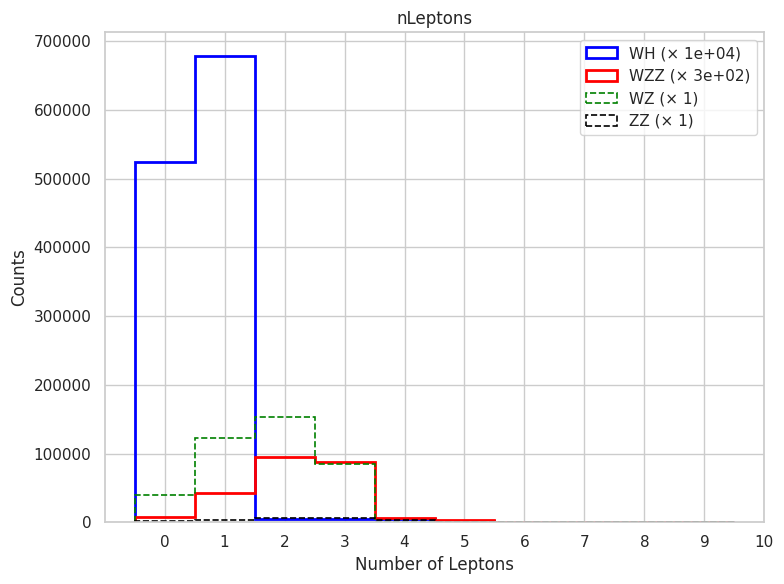

In [8]:
# Colors and factors from Part I
lepton_counts = {}

# Count leptons for signals
for label, arr in signal_data.items():
    n_electrons = ak.num(arr["el_pt"])
    n_muons = ak.num(arr["mu_pt"])
    lepton_counts[label] = ak.to_numpy(n_electrons + n_muons)

# Count leptons for backgrounds
for label, arr in background_data.items():
    n_electrons = ak.num(arr["el_pt"])
    n_muons = ak.num(arr["mu_pt"])
    lepton_counts[label] = ak.to_numpy(n_electrons + n_muons)
    
plt.figure(figsize=(8, 6))
bins = np.arange(0, 10 + 1) - 0.5  # center bins on integer values

for label, nlep in lepton_counts.items():
    weight = norm_factors[label]
    multiplier = multiplicative_factors[label]
    display_label = f"{label} (× {multiplier:.2g})"

    if label in signal_colors:
        color = signal_colors[label]
        linestyle = '-'
        linewidth = 2
    else:
        color = background_colors[label]
        linestyle = '--'
        linewidth = 1.2

    plt.hist(
        nlep,
        bins=bins,
        alpha=1,
        label=display_label,
        histtype='step',
        color=color,
        linewidth=linewidth,
        linestyle=linestyle,
        weights=[weight] * len(nlep)
    )

plt.xlabel("Number of Leptons")
plt.ylabel("Counts")
plt.title("nLeptons")
plt.xticks(np.arange(0, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("nLeptons_normalized.png")
plt.show()


#Why does WH fall off after 1? 

### Plotting del_R before applying any cut

Loading WH...
Loading WZZ...
Loading WZ...
Loading ZZ...


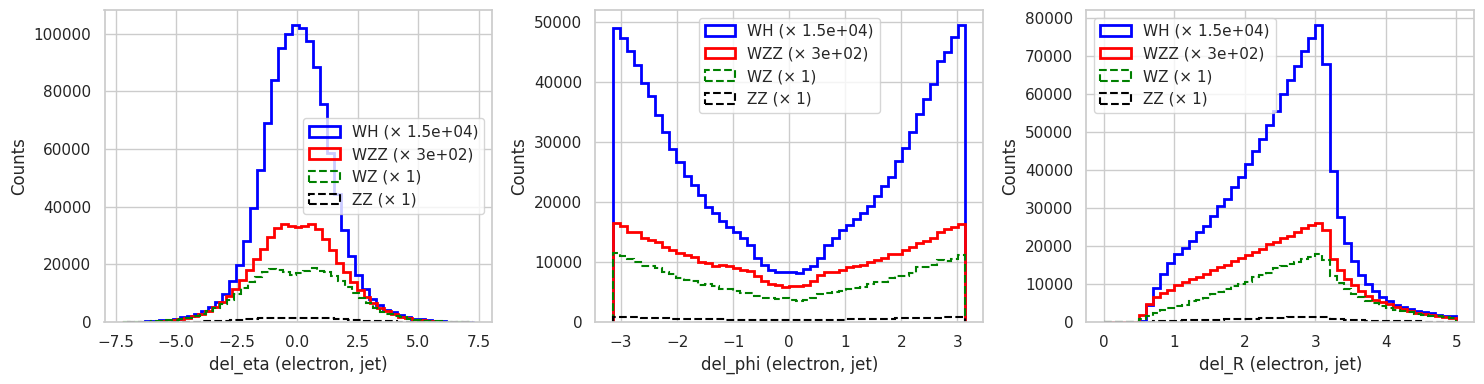

In [4]:
# label mapping for your files (adjust keys to match file_paths keys)
label_map = {0: "WH", 1: "WZZ", 2: "ZZ"}
colors = {0: "blue", 1: "red", 2: "black"}

# Normalization factors and multiplicative factors
norm_factors = {
    "WH": 0.0001218 * 15000,
    "WZZ": 0.0081 * 300,
    #"WZ": 4.0,
    "ZZ": 0.196
}
multiplicative_factors = {
    "WH": 15000,
    "WZZ": 300,
    #"WZ": 1.0,
    "ZZ": 1.0
}

signal_labels = {0, 1}  # WH and WZZ
background_labels = {2}  # WZ and ZZ

# plotting containers for all datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# function to compute delta phi wrapped to [-pi, pi]
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2 * np.pi) - np.pi

# loop over all files and plot
for label_val, (key, path) in enumerate(file_paths.items()):
    print(f"Loading {key}...")
    events = load_tree(path, branches)

    # zip electron and jet into convenient objects
    events["el"] = ak.zip({"eta": events.el_eta, "phi": events.el_phi})
    events["jet"] = ak.zip({"eta": events.jet_eta, "phi": events.jet_phi})

    # all el-jet pairs
    el_jet_pairs = ak.cartesian({"el": events.el, "jet": events.jet}, axis=1)

    #three dels
    delta_eta_el_jet = el_jet_pairs["el"].eta - el_jet_pairs["jet"].eta
    delta_phi_el_jet = delta_phi(el_jet_pairs["el"].phi, el_jet_pairs["jet"].phi)
    deltaR_el_jet = np.sqrt(delta_eta_el_jet**2 + delta_phi_el_jet**2)

    # flatten to 1D
    all_delta_eta = ak.to_numpy(ak.flatten(delta_eta_el_jet, axis=None))
    all_delta_phi = ak.to_numpy(ak.flatten(delta_phi_el_jet, axis=None))
    all_deltaR = ak.to_numpy(ak.flatten(deltaR_el_jet, axis=None))

    # style + weight
    label_name = label_map[label_val]
    weight = norm_factors[label_name]
    multiplier = multiplicative_factors[label_name]
    display_label = f"{label_name} (× {multiplier:.2g})"
    linestyle = '-' if label_val in signal_labels else '--'
    linewidth = 2 if label_val in signal_labels else 1.5

    # plot all three histograms
    axes[0].hist(all_delta_eta, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_eta), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[1].hist(all_delta_phi, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_phi), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[2].hist(all_deltaR, bins=50, range=(0, 5), histtype="step",
                 color=colors[label_val], weights=np.full(len(all_deltaR), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)

# label axes
axes[0].set_xlabel(r"del_eta (electron, jet)")
axes[0].set_ylabel("Counts")
axes[1].set_xlabel(r"del_phi (electron, jet)")
axes[1].set_ylabel("Counts")
axes[2].set_xlabel(r"del_R (electron, jet)")
axes[2].set_ylabel("Counts")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Loading WH...
Loading WZZ...
Loading WZ...
Loading ZZ...


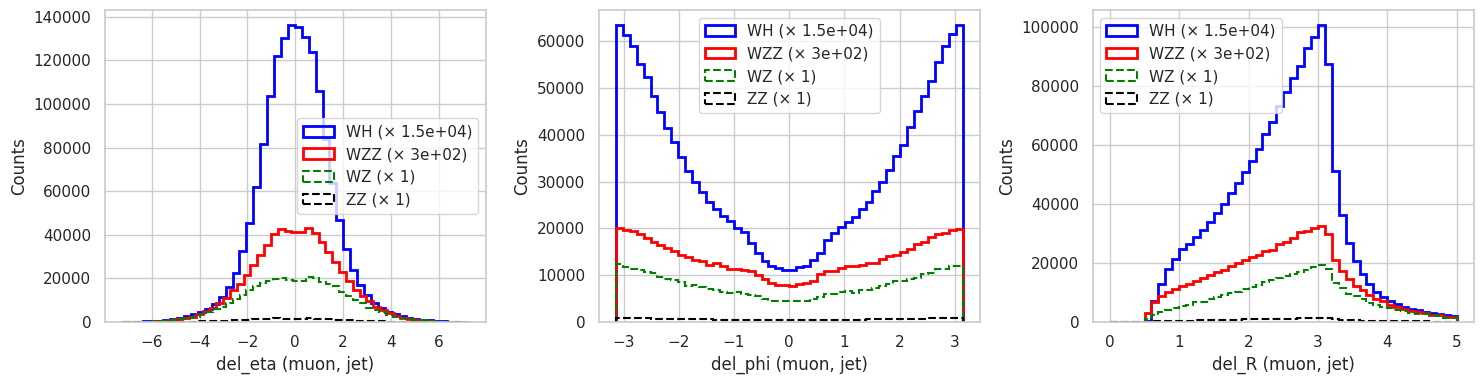

In [10]:
# label mapping
label_map = {0: "WH", 1: "WZZ", 2: "ZZ"}
colors = {0: "blue", 1: "red", 2: "black"}

#normaliz factors and multiplicative factors
norm_factors = {
    "WH": 0.0001218 * 15000,
    "WZZ": 0.0081 * 300,
    #"WZ": 4.0,
    "ZZ": 0.196
}
multiplicative_factors = {
    "WH": 15000,
    "WZZ": 300,
    #"WZ": 1.0,
    "ZZ": 1.0
}

signal_labels = {0, 1}  # WH and WZZ
background_labels = {2, 3}  # WZ and ZZ

# prepare plotting canvas
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# delta phi helper
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2 * np.pi) - np.pi

# loop over all datasets
for label_val, (key, path) in enumerate(file_paths.items()):
    print(f"Loading {key}...")
    events = load_tree(path, branches)

    # muon and jet objects
    events["mu"] = ak.zip({"eta": events.mu_eta, "phi": events.mu_phi})
    events["jet"] = ak.zip({"eta": events.jet_eta, "phi": events.jet_phi})

    # all muon–jet pairs
    mu_jet_pairs = ak.cartesian({"mu": events.mu, "jet": events.jet}, axis=1)

    #three dels
    delta_eta_mu_jet = mu_jet_pairs["mu"].eta - mu_jet_pairs["jet"].eta
    delta_phi_mu_jet = delta_phi(mu_jet_pairs["mu"].phi, mu_jet_pairs["jet"].phi)
    deltaR_mu_jet = np.sqrt(delta_eta_mu_jet**2 + delta_phi_mu_jet**2)

    # flatten to 1D arrays
    all_delta_eta = ak.to_numpy(ak.flatten(delta_eta_mu_jet, axis=None))
    all_delta_phi = ak.to_numpy(ak.flatten(delta_phi_mu_jet, axis=None))
    all_deltaR = ak.to_numpy(ak.flatten(deltaR_mu_jet, axis=None))

    # style + weights
    label_name = label_map[label_val]
    weight = norm_factors[label_name]
    multiplier = multiplicative_factors[label_name]
    display_label = f"{label_name} (× {multiplier:.2g})"
    linestyle = '-' if label_val in signal_labels else '--'
    linewidth = 2 if label_val in signal_labels else 1.5

    # plot
    axes[0].hist(all_delta_eta, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_eta), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[1].hist(all_delta_phi, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_phi), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[2].hist(all_deltaR, bins=50, range=(0, 5), histtype="step",
                 color=colors[label_val], weights=np.full(len(all_deltaR), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)

# axis labels and formatting
axes[0].set_xlabel(r"del_eta (muon, jet)")
axes[0].set_ylabel("Counts")
axes[1].set_xlabel(r"del_phi (muon, jet)")
axes[1].set_ylabel("Counts")
axes[2].set_xlabel(r"del_R (muon, jet)")
axes[2].set_ylabel("Counts")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


## Calling Features and Functions, to implement selection cuts and construct features for NN

In [144]:
all_datasets = {
    "WH": signal_data["WH"],
    "WZZ": signal_data["WZZ"],
    #"WZ": background_data["WZ"],
    "ZZ": background_data["ZZ"],
}

vector.register_awkward()   #tells vector to automatically interpret awkward arrays of dictionaries

 cuts filter events, so they must be applied while the data is still in the awkward.Array format — before converting to flat pandas DataFrames.

What the nLeptons == 3 cut is doing here:
- counts the total number of leptons before any qualitative cuts (like delR cleaning, pt > 10, |eta| < 2.5).
- selects events that appear to have exactly 3 leptons (muons + electrons).

### Main looper over files that a. implements cuts b. gets a df


In [3]:
dfs = []
label_map = {"WH": 0, "WZZ": 1, "ZZ": 2}
lepton_counts = {}

norm_factors = {
    "WH": 0.0001218,
    "WZZ": 0.0081,
    #"WZ": 4.0,
    "ZZ": 0.196   
}

for key, path in file_paths.items():
    print(f"Loading {key}...")
    #if key not in ["WH", "WZZ", "ZZ"]:  # exclude WZ
     #   continue
    events = load_tree(path, branches)

    #aapplying the full cleaning (includes kinematics + delR)
    events_cut = clean_leptons(events, deltaR_cut=0.4, pt_min=10, eta_max=2.5)
    
    nElectrons = ak.num(events_cut.el_pt, axis=1)
    nMuons = ak.num(events_cut.mu_pt, axis=1)     #counter for leptons
    nLeptons = nElectrons + nMuons
    lepton_counts[key] = nLeptons

    events_cut = events_cut[nLeptons >= 4] #require geq 4

    #Extracting features ONLY AFTER MAKING THE CUTS AHA! 3 leptons 
    df = extract_features_geq4lep(events_cut, label_map[key])
    df.dropna(inplace=True)
    
    weighted_events = df.shape[0] * norm_factors[key]
    print(f"{df.shape[0]} raw events, {weighted_events:.3f} weighted events")

    dfs.append(df)


Loading WH...
m_4lep: [212.80872587 240.17872899 195.30203682 300.54111772 232.43890042]
total_event_et: [344.7875747680664 346.7116889953613 249.09354782104492 520.425609588623
 275.19238471984863]
MT_lep_MET: [38.19860702588488 65.52921100617549 69.86159743306895 279.5034999396872
 90.87647539765366]
best_Z1_mass_mu: [-999.0 62.01234752595816 -999.0 187.95455002627205 -999.0]
best_Z2_mass_mu: [-999.0 120.58280911300474 -999.0 -999.0 -999.0]
best_Z1_mass_el: [62.40931039514233 62.326227503372074 98.14006385069402 62.172167822650295
 61.12735497615379]
best_Z2_mass_el: [55.87785393966018 -999.0 103.44945967837303 -999.0 59.83692908111615]
m12: [62.40931039514233 62.326227503372074 103.44945967837303
 62.172167822650295 165.9570192601829]
m13: [74.78177962577347 127.23335188021854 60.06123470204241 187.95455002627205
 52.75104580430264]
m14: [62.40931039514233 62.326227503372074 103.44945967837303
 62.172167822650295 165.9570192601829]
m23: [74.78177962577347 127.23335188021854 60.06123

In [5]:
print(dfs)

[         el_pt_0    el_eta_0    el_phi_0     mu_pt_0  mu_eta_0  mu_phi_0  \
4      44.304546   -2.323046    1.303429   44.012695 -1.619960  1.751673   
20     65.818207   -0.717262    2.985864   30.909138 -1.880553 -2.128735   
22     38.652912    0.161427    1.602454   22.961887  1.113702 -2.171827   
36   -999.000000 -999.000000 -999.000000  149.272934 -1.710134  2.850216   
41     33.654648    1.147468    1.183023   42.952179 -0.723555  1.593396   
...          ...         ...         ...         ...       ...       ...   
5294   49.322803   -0.907461    0.690691   94.863564 -0.565184 -2.562727   
5307   33.666210   -1.680635   -1.273846   66.120735 -1.462334  1.226222   
5313   29.579706    0.695591    0.969450   82.834244  1.139641 -1.830442   
5317   37.164429   -1.180989   -0.798523   71.549538 -1.251825  1.747944   
5328   55.519932    1.960747    3.048250   29.366619  2.363205 -0.425880   

         el_pt_1    el_eta_1    el_phi_1     mu_pt_1  ...    dphi34  deltaR12  \
4    

In [6]:
print(df[["m_4lep", "best_Z1_mass_mu", "best_Z2_mass_mu", "best_Z1_mass_el", "best_Z2_mass_el",
          "total_event_et", "MT_lep_MET", "pt_4lepsys", "dphi_met_4lepsys", "del_phi_bestZs",
          "m12", "m13", "m14", "m23", "m24", "m34", "m123", "m124", "m134", "m234", "deta12", 
          "deta13", "deta14", "deta23", "deta24", "deta34", "dphi12", "dphi13", "dphi14", 
          "dphi23", "dphi24", "dphi34", "deltaR12", "deltaR13", "deltaR14", "deltaR23", 
          "deltaR24", "deltaR34", "sphericity", "aplanarity",]].isna().sum())


m_4lep              0
best_Z1_mass_mu     0
best_Z2_mass_mu     0
best_Z1_mass_el     0
best_Z2_mass_el     0
total_event_et      0
MT_lep_MET          0
pt_4lepsys          0
dphi_met_4lepsys    0
del_phi_bestZs      0
m12                 0
m13                 0
m14                 0
m23                 0
m24                 0
m34                 0
m123                0
m124                0
m134                0
m234                0
deta12              0
deta13              0
deta14              0
deta23              0
deta24              0
deta34              0
dphi12              0
dphi13              0
dphi14              0
dphi23              0
dphi24              0
dphi34              0
deltaR12            0
deltaR13            0
deltaR14            0
deltaR23            0
deltaR24            0
deltaR34            0
sphericity          0
aplanarity          0
dtype: int64


In [7]:
type(dfs)
print(len(dfs))
print(type(dfs[0]))
print(dfs[0].columns)


3
<class 'pandas.core.frame.DataFrame'>
Index(['el_pt_0', 'el_eta_0', 'el_phi_0', 'mu_pt_0', 'mu_eta_0', 'mu_phi_0',
       'el_pt_1', 'el_eta_1', 'el_phi_1', 'mu_pt_1', 'mu_eta_1', 'mu_phi_1',
       'el_pt_2', 'el_eta_2', 'el_phi_2', 'mu_pt_2', 'mu_eta_2', 'mu_phi_2',
       'el_pt_3', 'el_eta_3', 'el_phi_3', 'mu_pt_3', 'mu_eta_3', 'mu_phi_3',
       'jet_pt_0', 'jet_eta_0', 'jet_phi_0', 'jet_pt_1', 'jet_eta_1',
       'jet_phi_1', 'jet_mass_0', 'jet_btag_0', 'MET', 'MET_Phi', 'm_4lep',
       'total_event_et', 'MT_lep_MET', 'pt_4lepsys', 'dphi_met_4lepsys',
       'best_Z1_mass_mu', 'best_Z2_mass_mu', 'best_Z1_mass_el',
       'best_Z2_mass_el', 'del_phi_bestZs', 'm12', 'm13', 'm14', 'm23', 'm24',
       'm34', 'm123', 'm124', 'm134', 'm234', 'deta12', 'deta13', 'deta14',
       'deta23', 'deta24', 'deta34', 'dphi12', 'dphi13', 'dphi14', 'dphi23',
       'dphi24', 'dphi34', 'deltaR12', 'deltaR13', 'deltaR14', 'deltaR23',
       'deltaR24', 'deltaR34', 'sphericity', 'aplanarity', 'la

dfs is a list of 4 DataFrames (one per class). Each individual item in dfs (like dfs[0], dfs[1], ...) is a proper pandas DataFrame and includes a label column already.

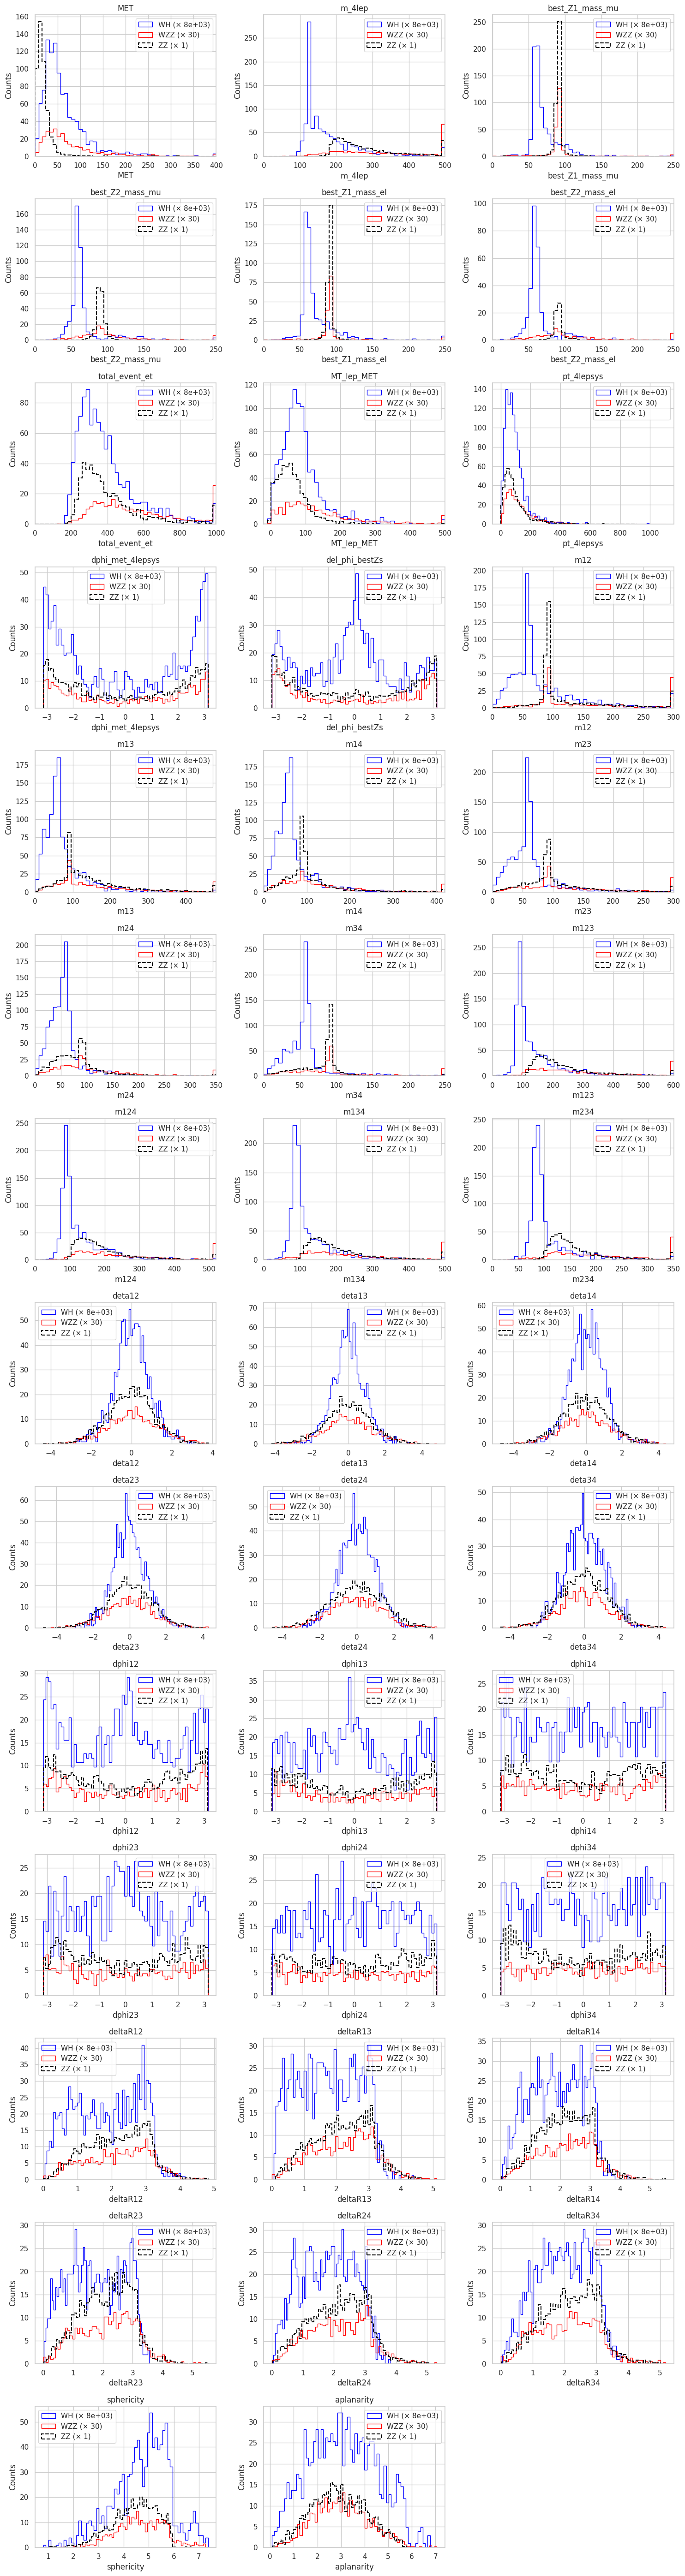

In [8]:

df = pd.concat(dfs, ignore_index=True)

label_map = {0: "WH", 1: "WZZ", 2: "ZZ"}
colors = {0: "blue", 1: "red", 2:"black"}

# Normalization factors and multiplicative factors from Part I
norm_factors = {
    "WH": 0.0001218* 8000,
    "WZZ": 0.0081 * 30,
   # "WZ": 4.0,
    "ZZ": 0.196
}

multiplicative_factors = {
    "WH": 8000,
    "WZZ":  30,
    #"WZ": 1.0,
    "ZZ": 1.0
}
x_limits = {
    "MET": (0, 400),
    "m_4lep": (0, 500),
    "total_event_et": (0, 1000),
    "MT_lep_MET": (-20, 500),
    "best_Z1_mass_mu": (0, 250),
    "best_Z1_mass_el": (0, 250),
    "best_Z2_mass_el": (0, 250),
    "best_Z2_mass_mu": (0, 250),
    "m12":(0,300),
    "m13":(0,480), 
    "m14":(0,420), 
    "m23":(0,300),  
    "m24":(0,350), 
    "m34":(0, 250), 
    "m123":(0,600), 
    "m124":(0,520), 
    "m134":(0,500), 
    "m234":(0, 350),
    

     
    
     
}

features = ["MET", "m_4lep", "best_Z1_mass_mu", "best_Z2_mass_mu", "best_Z1_mass_el", "best_Z2_mass_el", "total_event_et", "MT_lep_MET",
            "pt_4lepsys", "dphi_met_4lepsys", "del_phi_bestZs", "m12", "m13", "m14", "m23", "m24", "m34", "m123", "m124", "m134", 
            "m234", "deta12", "deta13", "deta14", "deta23", "deta24", "deta34", "dphi12", "dphi13", "dphi14", "dphi23", "dphi24", 
            "dphi34", "deltaR12", "deltaR13", "deltaR14", "deltaR23", "deltaR24", "deltaR34","sphericity", "aplanarity"]

n_features = len(features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

signal_labels = {0, 1}  # WH and WZZ
background_labels = {2}  # WZ and ZZ

for i, feature in enumerate(features):
    ax = axes[i]

    #bins for overflow handling
    if feature in x_limits:
        xmin, xmax = x_limits[feature]
        bins = np.linspace(xmin, xmax, 51)  # 50 bins
    else:
        #binning for other features, default
        bins = 65

    for label_val, label_name in label_map.items():
        subset = df[df["label"] == label_val][feature].dropna()

        #clip to overflow bin range
        if feature in x_limits:
            subset = subset.clip(upper=x_limits[feature][1])

        weight = norm_factors[label_name]
        multiplier = multiplicative_factors[label_name]
        display_label = f"{label_name} (× {multiplier:.2g})"
        linestyle = '-' if label_val in signal_labels else '--'
        linewidth = 1 if label_val in signal_labels else 1.5

        ax.hist(subset,
                bins=bins,
                weights=np.full(len(subset), weight),
                label=display_label,
                color=colors[label_val],
                linewidth=linewidth,
                linestyle=linestyle,
                histtype='step')

    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()

    #x-limits for display
    if feature in x_limits:
        ax.set_xlim(x_limits[feature])

#hiding unused axes
for i in range(len(features), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()



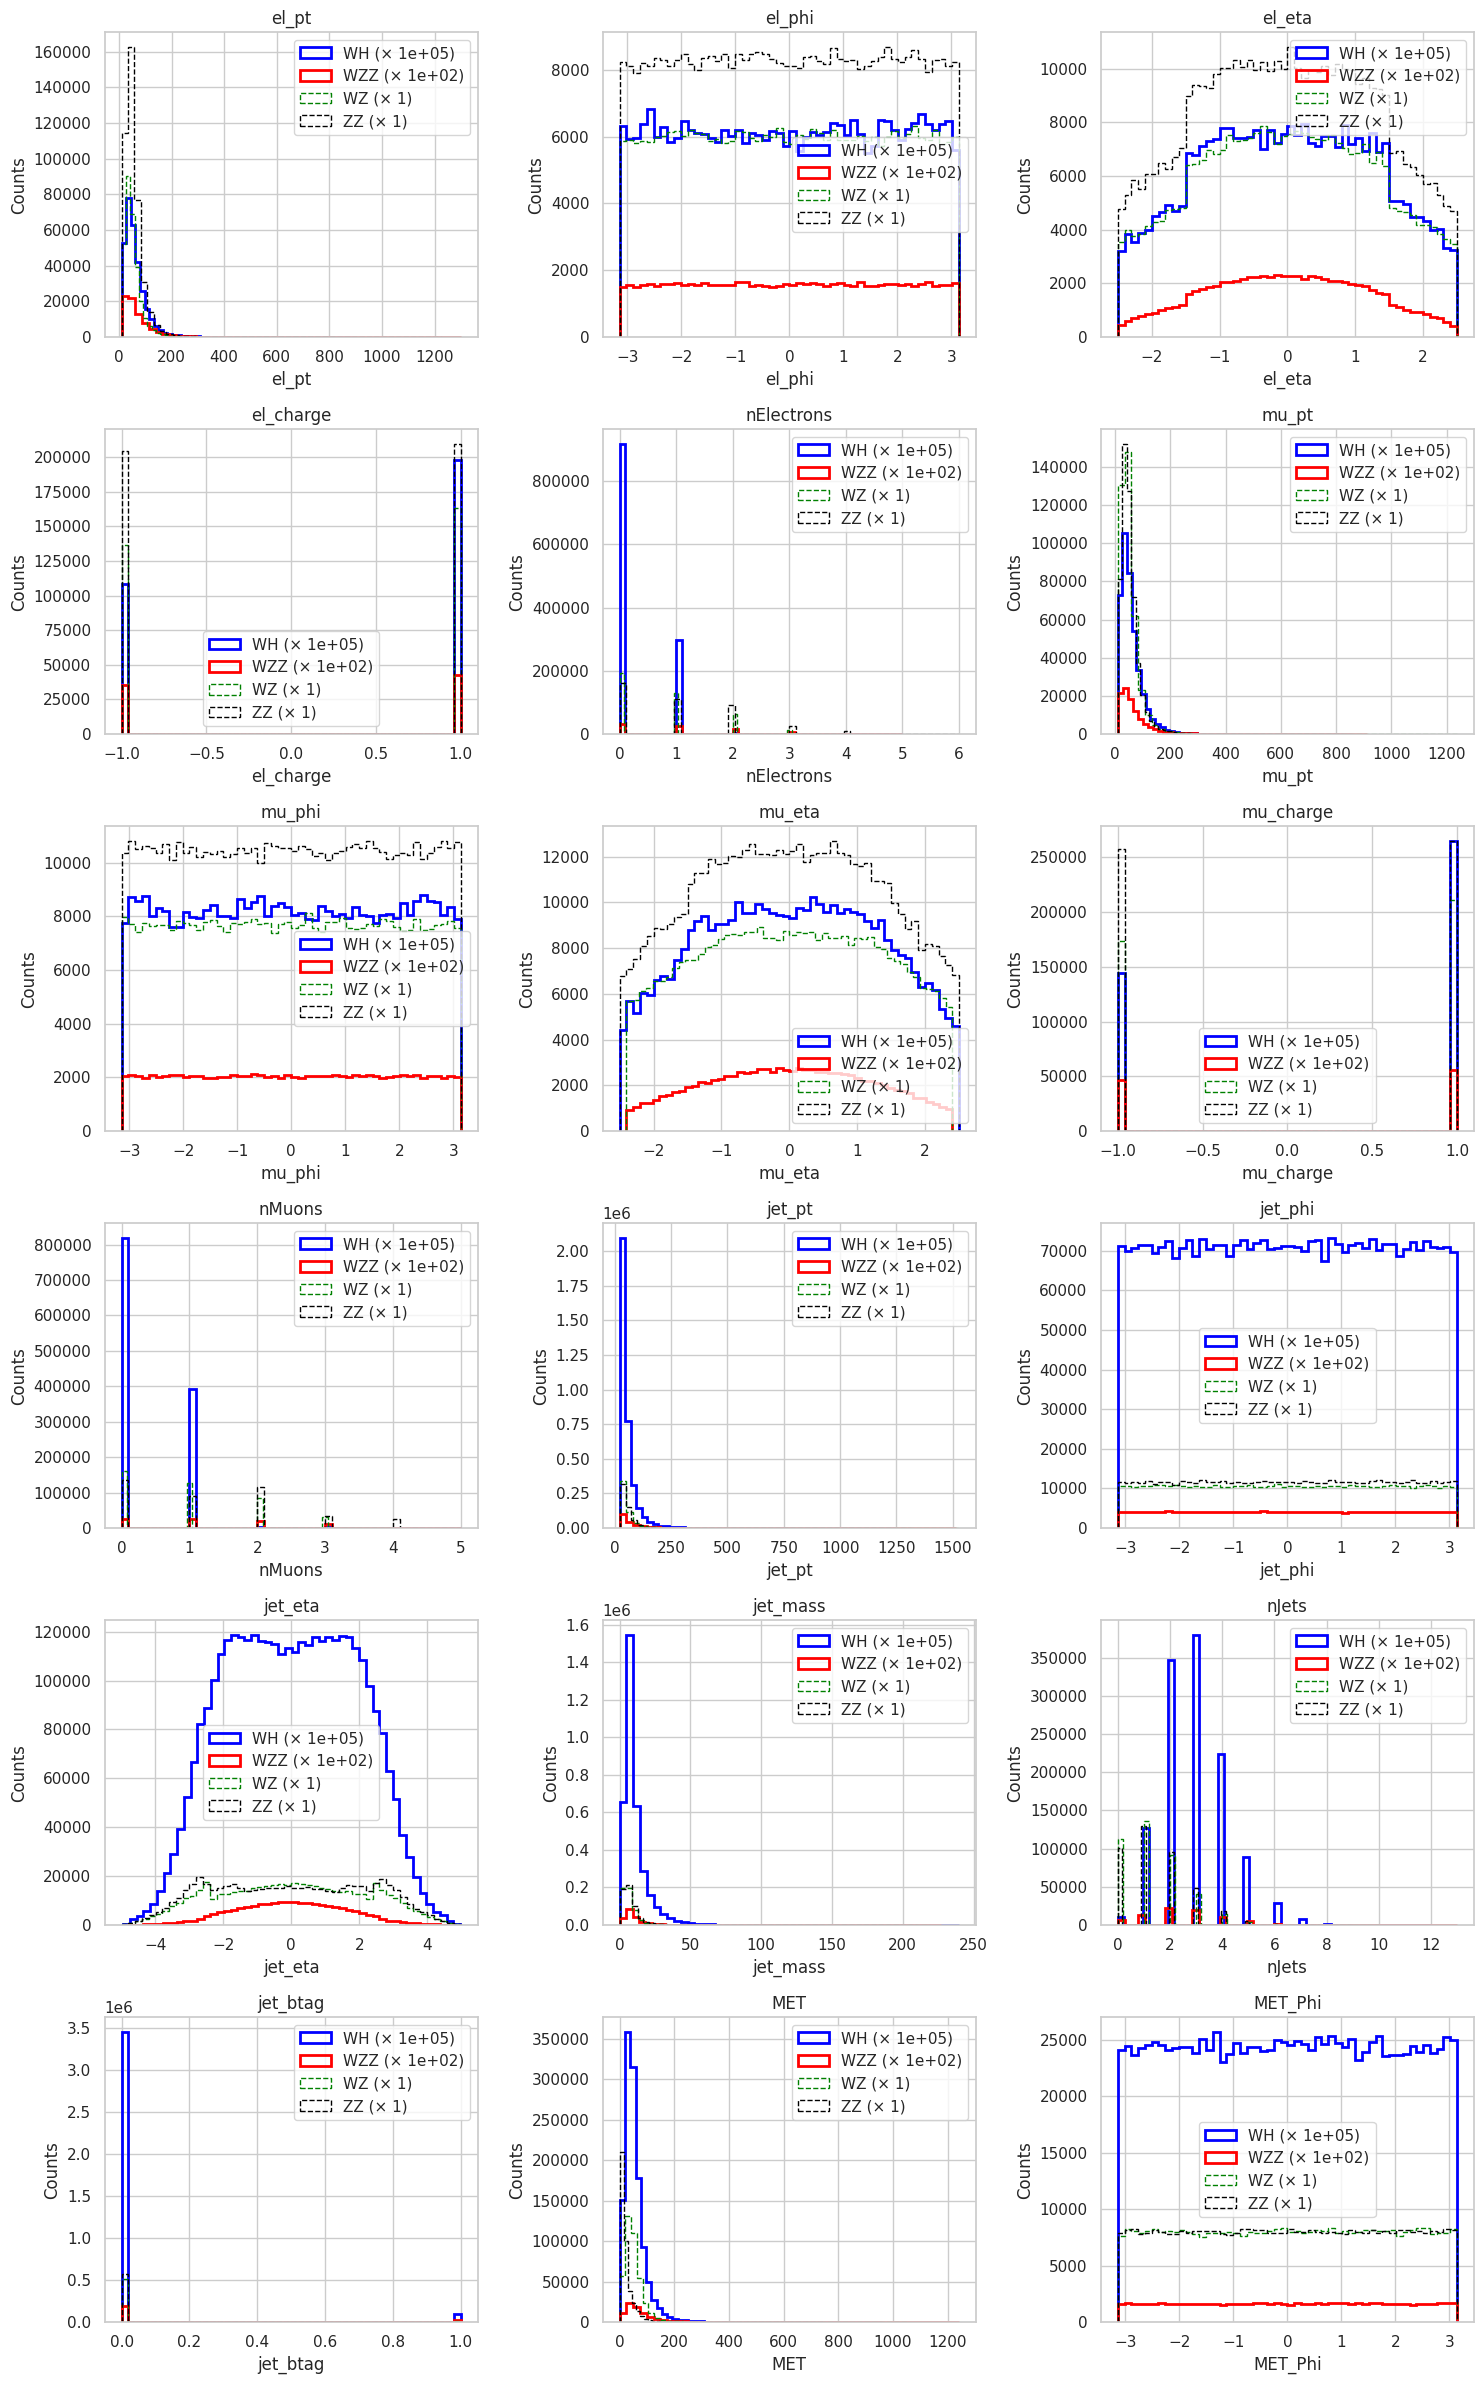

In [29]:
#Plotting right after the cuts are applied, for sanity
n_cols = 3
n_rows = int(np.ceil(len(branches) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))   #plot layout
axes = axes.flatten()


for i, var in enumerate(branches):
    ax = axes[i]             #main loop for plot

    #sig
    for label, arr in signal_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=2,
            density=False,
            label=display_label,
            linestyle='-',
            color=signal_colors[label],
            weights=[weight] * len(values)
        )

    #backg
    for label, arr in background_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=1,
            density=False,
            label=display_label,
            linestyle='--',
            color=background_colors[label],
            weights=[weight] * len(values)
        )

    ax.set_xlabel(var)
    ax.set_ylabel("Counts")
    ax.set_title(f"{var}")
    ax.legend()


for j in range(len(branches), len(axes)):   #get rid of unused subplots
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Combined_normalized_aftercuts.png")
plt.show()

# Neural Network, Construction and Training

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np

#combining
df_all = pd.concat(dfs, ignore_index=True)

# Drop unwanted columns
df_all = df_all.drop(columns=['el_phi_3', 'deta23', 'deta14', 'mu_eta_1','jet_phi_0','mu_phi_3','dphi34','dphi12', 'el_pt_0', 'deta13',
                             'jet_phi_1', 'deta12','aplanarity','mu_phi_1','jet_eta_0', 'jet_eta_1', 'dphi14', 'MET_Phi', 'jet_pt_1','dphi24',
                              'dphi13', 'dphi23', 'jet_btag_0'  ])


feature_names = df_all.drop(columns=['label']).columns.to_numpy()

#separating out features and labels
X = df_all.drop(columns=['label']).values
y = df_all['label'].values

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

  #two step split
#Train + temp (validation+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42, shuffle=True    #(shuffle=True) 
)

#Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42, shuffle=True
)



2025-08-28 13:28:59.909230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756405739.919251 1598650 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756405739.922052 1598650 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756405739.929798 1598650 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756405739.929805 1598650 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756405739.929806 1598650 computation_placer.cc:177] computation placer alr

Features shape: (4741, 51)
Labels shape: (4741,)


In [10]:
#scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# One-hot encode labels
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (3318, 51) (3318,)
Validation: (711, 51) (711,)
Test: (712, 51) (712,)


In [11]:
print(X_train)
print(X_test)
print(X_val)

[[-9.99000000e+02 -9.99000000e+02  1.15702377e+02 ...  2.83704731e+00
   2.20174168e+00  5.76812472e+00]
 [-1.12673736e+00 -2.22020769e+00  7.60820847e+01 ...  1.33904898e+00
   3.19986367e+00  5.03337828e+00]
 [ 8.25474918e-01 -2.06741881e+00  6.41856766e+01 ...  2.17242468e+00
   1.60844417e+00  5.21770169e+00]
 ...
 [-9.99000000e+02 -9.99000000e+02  4.33192406e+01 ...  1.22094094e+00
   1.86067792e+00  6.60152329e+00]
 [-9.99000000e+02 -9.99000000e+02  1.31864441e+02 ...  3.02958697e+00
   1.58051465e+00  3.69570129e+00]
 [ 9.06144232e-02  2.97097057e-01  7.83754272e+01 ...  2.07709697e+00
   1.78173292e+00  4.38944411e+00]]
[[-1.11849308e+00 -2.97651219e+00  2.63086300e+01 ...  3.00161402e+00
   1.49597845e+00  3.32428937e+00]
 [-9.99000000e+02 -9.99000000e+02  3.20099579e+02 ...  3.42353352e+00
   2.96057146e+00  5.73429806e+00]
 [ 3.13555241e-01  8.70708883e-01 -9.99000000e+02 ...  3.18957214e+00
   7.40047497e-01  3.40137307e+00]
 ...
 [-9.99000000e+02 -9.99000000e+02  1.8502555

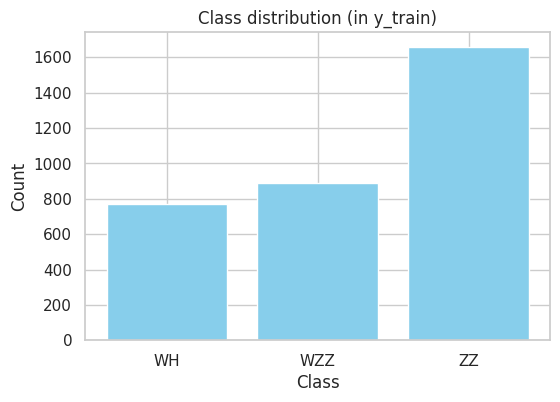

In [12]:

#Class contribution/Visualising the imbalance in classes

label_map = {0: "WH", 1: "WZZ", 2: "ZZ"}
unique_classes, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar([label_map[c] for c in unique_classes], counts, color='skyblue')
plt.xticks(unique_classes)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution (in y_train)")
plt.show()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

#computing class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
cw = dict(zip(np.unique(y_train), class_weights))

#identify the number of calsses directly
n_classes = len(np.unique(y))

#early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

#main model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=100,
    batch_size=128,
    validation_data=(X_val_scaled, y_val_cat),
    class_weight=cw,               #using class weights and callbacks/early stopping now 
    callbacks=[early_stop],        
    verbose=1
)

#play with dense
#regularization/
#see if gridsearch exists
#X_train_scaled.shape[1]?
#minimization of learning rate

#make bar plot to visualize class imbalance before training. balance weights
#prediction for each class (bar plot), probabilities



Epoch 1/100


/users/dbhandari/WZZtest/proj/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-28 13:29:02.539225: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4478 - loss: 1.2772 - val_accuracy: 0.6540 - val_loss: 0.8634
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6488 - loss: 0.8904 - val_accuracy: 0.7862 - val_loss: 0.7314
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6918 - loss: 0.8007 - val_accuracy: 0.7961 - val_loss: 0.6647
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7309 - loss: 0.7184 - val_accuracy: 0.8143 - val_loss: 0.6253
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7348 - loss: 0.7003 - val_accuracy: 0.8242 - val_loss: 0.5751
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7530 - loss: 0.6718 - val_accuracy: 0.8242 - val_loss: 0.5348
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 0.6309 - val_accuracy: 0.8312 - val_loss: 0.5126
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7954 - loss: 0.5804 - val_accuracy: 0.8340 - val_loss: 0.4

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0
0

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85       166
           1       0.80      0.71      0.75       190
           2       0.91      0.94      0.93       356

    accuracy                           0.86       712
   macro avg       0.84      0.84      0.84       712
weighted avg       0.86      0.86      0.86       712

Confusion Matrix:
 [[145  14   7]
 [ 30 134  26]
 [  2  19 335]]


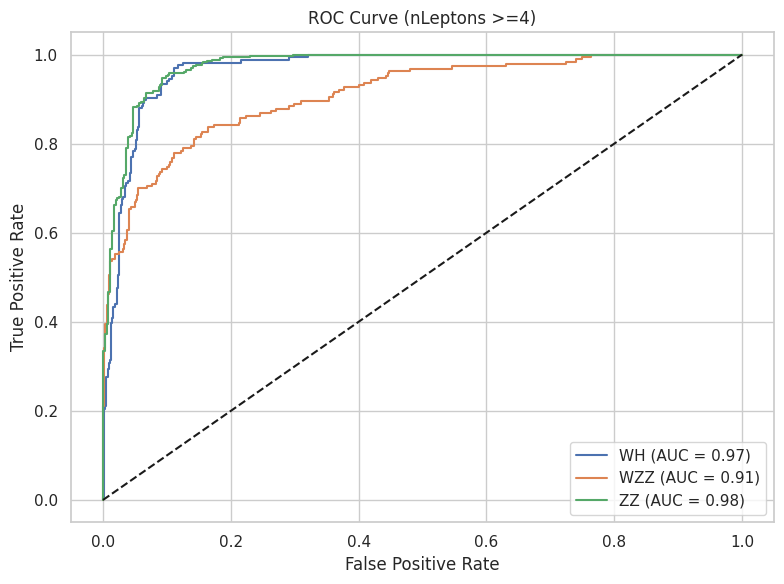

In [14]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#Model Evaluation
test_preds = model.predict(X_test_scaled)
test_preds_label = np.argmax(test_preds, axis=1)

print(np.isnan(X_test).sum())
print(np.isnan(test_preds).sum())

print("\nClassification Report:\n", classification_report(y_test, test_preds_label))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds_label))
# Define your class names in the order of their numeric labels
class_names = ["WH", "WZZ", "ZZ"]

#ROC for each class
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], test_preds[:, i])
    auc_score = roc_auc_score(y_test_cat[:, i], test_preds[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (nLeptons >=4)")
plt.legend()
plt.tight_layout()
plt.savefig("geq4lep_ROC.png", dpi=300, bbox_inches='tight')
plt.show()

#make confusion matrix 


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


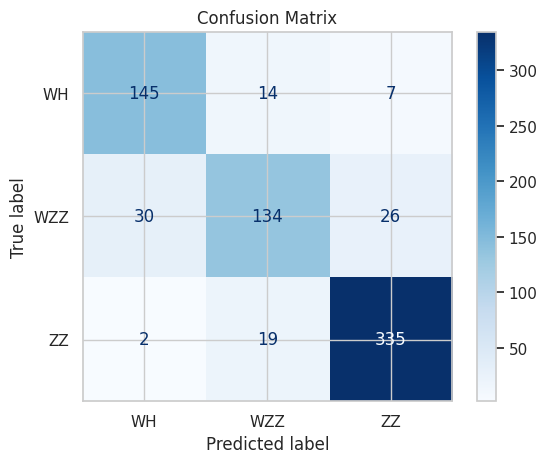

In [15]:
class_names = ["WH", "WZZ", "ZZ"]


#Predictions (probabilities -> predicted class index)
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

#Converting one-hot y_test back to class indices
y_true_classes = np.argmax(y_test_cat, axis=1)

#confusion matrix main comp
cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')  # 'd' = integer display
plt.title("Confusion Matrix")
plt.show()

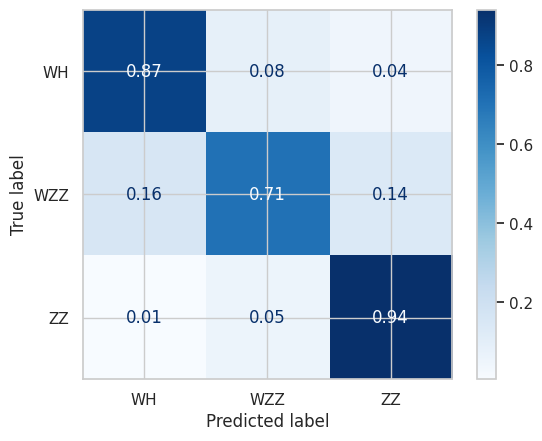

In [16]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap='Blues', values_format='.2f')


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


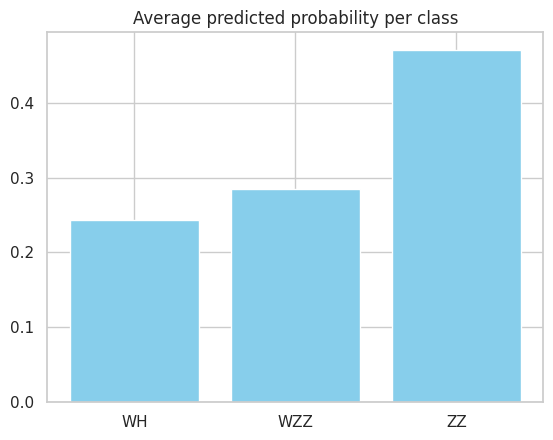

In [17]:
#Predicted probability per Class

label_map = {0: "WH", 1: "WZZ", 2: "ZZ"}

y_pred_proba = model.predict(X_val_scaled)
avg_probs = np.mean(y_pred_proba, axis=0)
plt.bar([label_map[c] for c in unique_classes], avg_probs, color='skyblue')
plt.title("Average predicted probability per class")
plt.show()

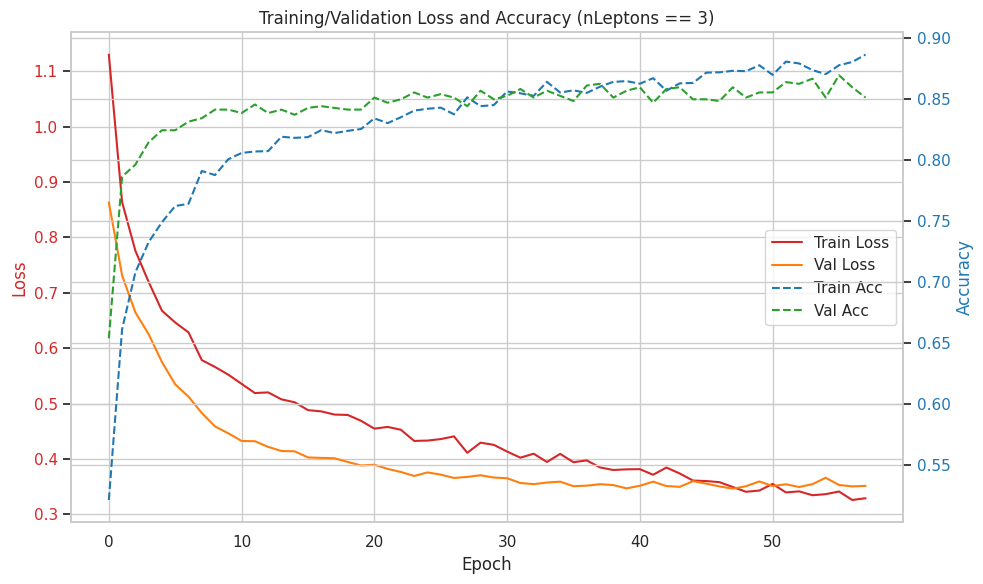

In [18]:
import matplotlib.pyplot as plt

#main fig and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Loss (left y-axis)
ax1.plot(history.history['loss'], label='Train Loss', color='tab:red')
ax1.plot(history.history['val_loss'], label='Val Loss', color='tab:orange')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# secondary y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='Train Acc', color='tab:blue', linestyle='--')
ax2.plot(history.history['val_accuracy'], label='Val Acc', color='tab:green', linestyle='--')
ax2.set_ylabel("Accuracy", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

#combining legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

plt.title("Training/Validation Loss and Accuracy (nLeptons == 3)")
plt.grid(True)
plt.tight_layout()
plt.savefig("3Lep_LossAcc.png", dpi=300, bbox_inches='tight')
plt.show()

#overfitting! What's not right?

/users/dbhandari/WZZtest/proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 201it [00:18,  8.66it/s]                         
/tmp/ipykernel_1598650/1252622081.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


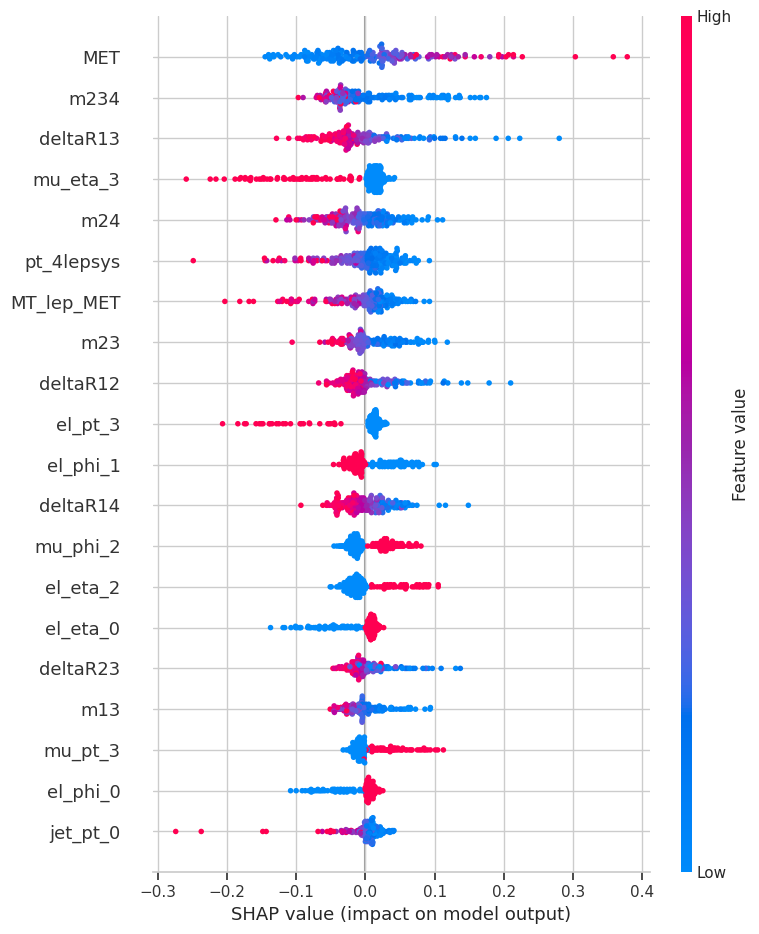

In [19]:
import shap
import numpy as np

X_explain = X_train_scaled[:500]
explainer = shap.Explainer(model, X_explain)

shap_values = explainer(X_test_scaled[:200])

shap.summary_plot(
    shap_values.values[..., 0],
    X_test_scaled[:200],
    feature_names=feature_names
)
plt.tight_layout()
plt.savefig("4Lep_SHAP_summary_new.png", dpi=300)
plt.close()


PermutationExplainer explainer: 201it [00:10,  1.39it/s]                         


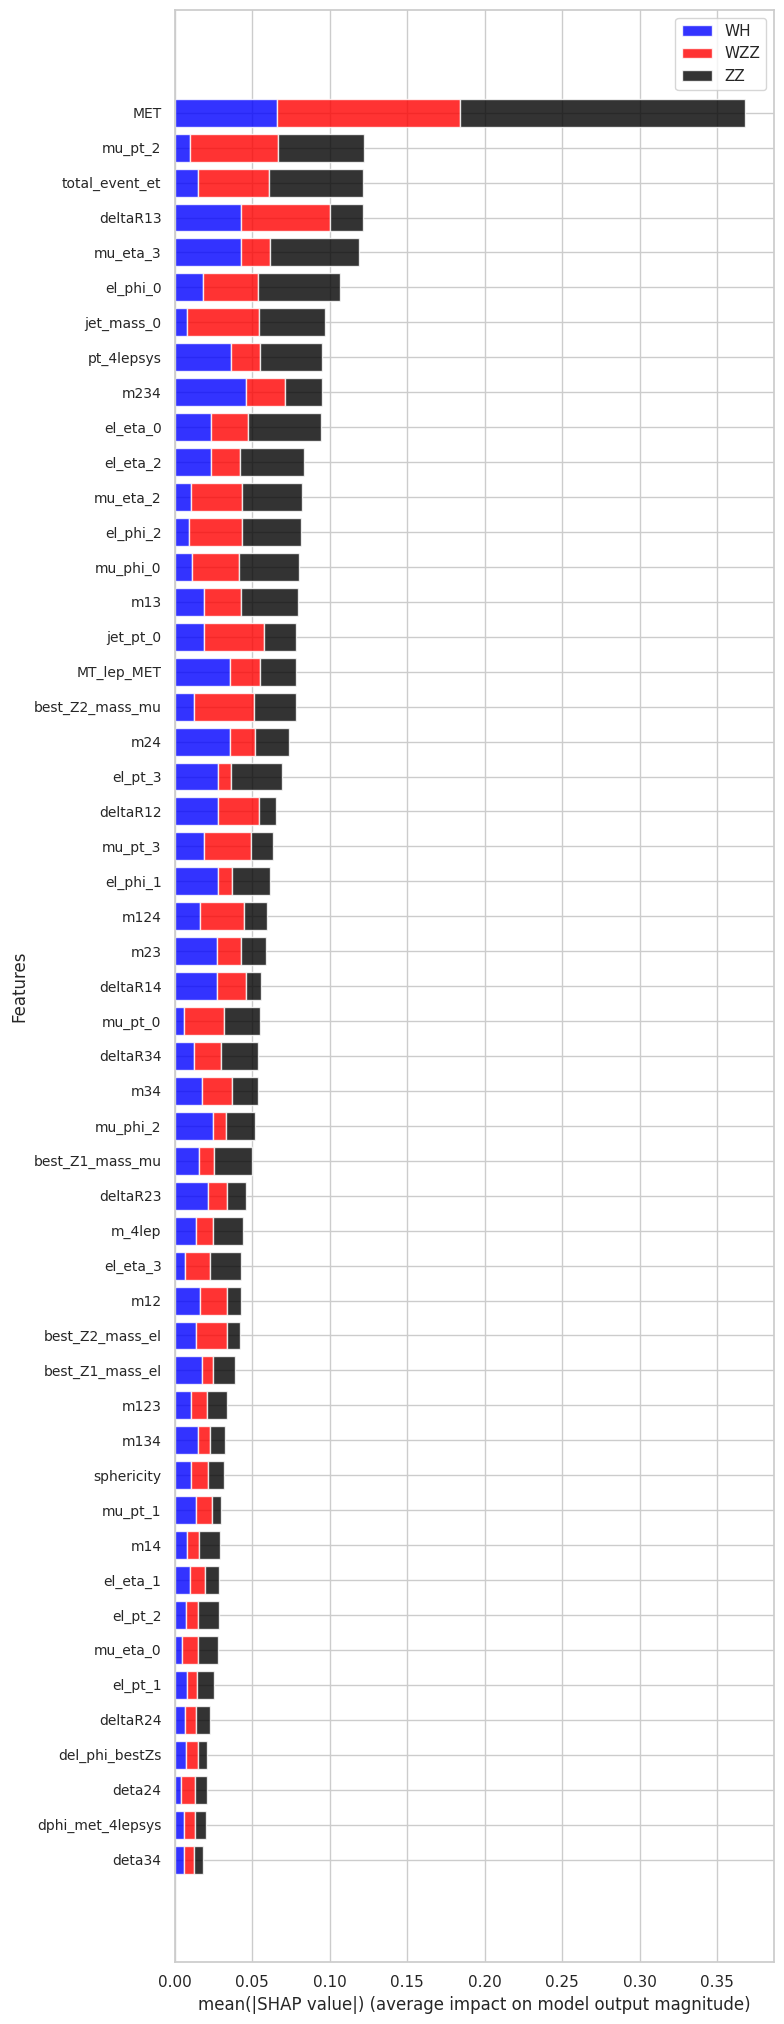

In [20]:


# Take subset for SHAP to speed up
X_explain = X_train_scaled[:500]
explainer = shap.Explainer(model, X_explain)
shap_values = explainer(X_test_scaled[:200])

# shap_values.values has shape (n_samples, n_features, n_classes)
vals = np.abs(shap_values.values).mean(axis=0)  # mean(|SHAP|) over samples → shape (n_features, n_classes)

# Prepare feature importances
feature_importance = vals  # (n_features, n_classes)
features = feature_names

# Class labels (adjust to your case)
class_labels = ["WH", "WZZ", "ZZ"]
colors = ["blue", "red", "black"]

# Sort features by total importance
sorted_idx = np.argsort(feature_importance.sum(axis=1))[::-1]
features_sorted = [features[i] for i in sorted_idx]
importance_sorted = feature_importance[sorted_idx]

# Adjust figure height based on number of features
fig_height = max(6, 0.4 * len(features_sorted))  # 0.4 inch per feature, minimum 6
fig, ax = plt.subplots(figsize=(8, fig_height))

bottom = np.zeros(len(features_sorted))
for cls_idx, (cls_label, color) in enumerate(zip(class_labels, colors)):
    ax.barh(
        features_sorted,
        importance_sorted[:, cls_idx],
        left=bottom,
        label=cls_label,
        color=color,
        alpha=0.8
    )
    bottom += importance_sorted[:, cls_idx]

ax.set_xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
ax.set_ylabel("Features")
ax.legend()

# Flip y-axis so most important features are at the top
ax.invert_yaxis()

# Reduce font size for feature names
ax.tick_params(axis="y", labelsize=10)  # smaller font on y-axis labels
plt.tight_layout()

plt.savefig("geq4Lep_SHAP_stacked.png")
plt.show()



In [21]:

def asimov_Z(s, b, eps=1e-12):
    
    s = float(s); b = float(b)
    if s <= 0: 
        return 0.0  #asimov no systematics
    if b <= 0:
        return np.sqrt(2.0*s)  # conservative limit for b→0
    return np.sqrt(2.0 * ((s + b) * np.log(1.0 + s / (b + eps)) - s))

def asimov_ovr_from_softmax(
    y_true,             # integer class labels, shape (N,)
    y_pred_proba,       # softmax probs, shape (N, C)
    class_names,        # list like in index order
    xsec_fb,            # dict: class_name -> cross section in fb
    lumi_fb             # float luminosity in fb^-1
):
    """
    One-vs-rest Asimov Z for a multi-class classifier.
    Uses argmax(y_pred_proba) as the selection for each class.
    """
    y_true = np.asarray(y_true)
    y_pred = np.argmax(y_pred_proba, axis=1)
    n_classes = len(class_names)

    # sanity checks
    assert y_pred_proba.shape[1] == n_classes, "class_names must match model outputs"
    for cls in class_names:
        assert cls in xsec_fb, f"Missing cross section for {cls}"

    # per-class totals
    N_per_cls = {i: int(np.sum(y_true == i)) for i in range(n_classes)}

    # build confusion-style counts:
    # selected_as[c][i] = # of true class i predicted as c
    selected_as = {
    c: {i: int(np.sum((y_true == i) & (y_pred == c))) for i in range(n_classes)}
    for c in range(n_classes)
}

    # compute efficiencies and yields, then Z
    Z = {}
    for c, cname in enumerate(class_names):
        # signal efficiency ε_s (fraction of true-c predicted as c)
        Nc = N_per_cls[c]
        tp = selected_as[c][c]
        eps_s = tp / Nc if Nc > 0 else 0.0

        # background efficiencies ε_b(k) per background class k ≠ c
        eps_b_per_k = {}
        for k in range(n_classes):
            if k == c: 
                continue
            Nk = N_per_cls[k]
            fp_k = selected_as[c][k]  # true k predicted as c
            eps_b_per_k[k] = fp_k / Nk if Nk > 0 else 0.0

        # expected yields from σ × L × ε
        S = xsec_fb[cname] * lumi_fb * eps_s
        B = 0.0
        for k, kname in enumerate(class_names):
            if k == c:
                continue
            B += xsec_fb[kname] * lumi_fb * eps_b_per_k[k]

        Z[cname] = asimov_Z(S, B)
        
        print(f"\nClass {cname}")
        print(f"  Nc = {Nc}, tp = {tp}, eps_s = {eps_s:.3f}")
        print(f"  eps_b_per_k = {eps_b_per_k}")
        print(f"  S = {S:.2f}, B = {B:.2f}")
    return Z



In [23]:
print("y_test shape:", y_test.shape)
print("y_pred_proba shape:", y_pred_proba.shape)
n = min(len(y_test), len(y_pred_proba))
y_test = y_test[:n]
y_pred_proba = y_pred_proba[:n]
print("y_test shape:", y_test.shape)
print("y_pred_proba shape:", y_pred_proba.shape)


y_test shape: (711,)
y_pred_proba shape: (711, 3)
y_test shape: (711,)
y_pred_proba shape: (711, 3)


In [24]:
class_names = ["WH", "WZZ", "ZZ"]

xsec_fb = {
    "WH": 0.379,         # fb
    "WZZ": 2.7,          # fb
    "ZZ": 61.56,         # fb (0.06156 pb)
}
lumi_fb = 320.0



# y_test: integer labels in 0..3 aligned with class_names order
# y_pred_proba: model.predict(X_test_scaled)
Z_asimov = asimov_ovr_from_softmax(y_test, y_pred_proba, class_names, xsec_fb, lumi_fb)
print(Z_asimov)



Class WH
  Nc = 166, tp = 36, eps_s = 0.217
  eps_b_per_k = {1: 0.2328042328042328, 2: 0.29213483146067415}
  S = 26.30, B = 5955.97

Class WZZ
  Nc = 189, tp = 57, eps_s = 0.302
  eps_b_per_k = {0: 0.23493975903614459, 2: 0.22191011235955055}
  S = 260.57, B = 4399.95

Class ZZ
  Nc = 356, tp = 173, eps_s = 0.486
  eps_b_per_k = {0: 0.5481927710843374, 1: 0.4656084656084656}
  S = 9572.93, B = 468.77
{'WH': 0.3405558520351172, 'WZZ': 3.8904399181658977, 'ZZ': 205.90642353067145}


In [25]:
def compute_significance_signals_only(results, yields, lumi=320.0):
    """
    Compute Asimov significance only for signals
    rest backgrounds
    
    results: dict with class efficiencies (like your eps_s, eps_b_per_k)
    yields: dict with cross sections {class: xsec_fb}
    lumi: luminosity in fb^-1
    """
    from math import sqrt, log
    
    def asimov(S, B):
        if S <= 0 or B <= 0:
            return 0.0
        return sqrt(2 * ((S + B) * log(1 + S / B) - S))

    significances = {}

    for signal_class in ["WH", "WZZ"]:
        S = results[signal_class]["eps_s"] * yields[signal_class] * lumi
        B = 0.0
        for bkg_class in ["WH", "WZZ", "ZZ"]:
            if bkg_class == signal_class:
                continue
            eps_b = results[signal_class]["eps_b_per_k"].get(
                list(yields.keys()).index(bkg_class), 0.0
            )
            B += eps_b * yields[bkg_class] * lumi
        significances[signal_class] = asimov(S, B)

    return significances


In [26]:
yields = {
    "WH": 0.379,   # fb
    "WZZ": 6.33,
    "ZZ": 62.0
}

# Using results dict structure
results = {
    "WH": {
        "Nc": 166,
        "tp": 35,
        "eps_s": 0.211,
        "eps_b_per_k": {1: 0.21164021164021163, 2: 0.28370786516853935},
        "S": 25.57,
        "B": 5771.68,
    },
    "WZZ": {
        "Nc": 189,
        "tp": 60,
        "eps_s": 0.317,
        "eps_b_per_k": {0: 0.27710843373493976, 2: 0.23314606741573032},
        "S": 274.29,
        "B": 4626.40,
    },
    "ZZ": {
        "Nc": 356,
        "tp": 172,
        "eps_s": 0.483,
        "eps_b_per_k": {0: 0.5120481927710844, 1: 0.4708994708994709},
        "S": 9517.59,
        "B": 468.96,
    }
}

print(compute_significance_signals_only(results, yields))


{'WH': 0.3285647165671632, 'WZZ': 9.202569578530774}
